In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load the dataset
data = pd.read_csv(f"QVI_data.csv")

# Display the first few rows to verify
print("Dataset Preview:")
print(data.head())


Dataset Preview:
         DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
0  2018-10-17          1            1000       1         5   
1  2019-05-14          1            1307     348        66   
2  2019-05-20          1            1343     383        61   
3  2018-08-17          2            2373     974        69   
4  2018-08-18          2            2426    1038       108   

                                  PROD_NAME  PROD_QTY  TOT_SALES  PACK_SIZE  \
0    Natural Chip        Compny SeaSalt175g         2        6.0        175   
1                  CCs Nacho Cheese    175g         3        6.3        175   
2    Smiths Crinkle Cut  Chips Chicken 170g         2        2.9        170   
3    Smiths Chip Thinly  S/Cream&Onion 175g         5       15.0        175   
4  Kettle Tortilla ChpsHny&Jlpno Chili 150g         3       13.8        150   

    BRAND               LIFESTAGE PREMIUM_CUSTOMER  
0     NCC   YOUNG SINGLES/COUPLES          Premium  
1     CCs  MIDAGE SINGLES/COU

## Select control stores

In [3]:
# Ensure the DATE column is in datetime format
data['DATE'] = pd.to_datetime(data['DATE'])

# Extract the month and year for aggregation
data['MONTH'] = data['DATE'].dt.to_period('M')

# Calculate metrics for each store and month
metrics = data.groupby(['STORE_NBR', 'MONTH']).agg(
    Monthly_Revenue=('TOT_SALES', 'sum'),
    Monthly_Customers=('LYLTY_CARD_NBR', 'nunique'),
    Monthly_Transactions=('TXN_ID', 'nunique')
).reset_index()

# Add monthly transactions per customer
metrics['Transactions_Per_Customer'] = metrics['Monthly_Transactions'] / metrics['Monthly_Customers']

# Preview the metrics
print("Metrics of Interest:")
print(metrics.head())


Metrics of Interest:
   STORE_NBR    MONTH  Monthly_Revenue  Monthly_Customers  \
0          1  2018-07            188.9                 47   
1          1  2018-08            168.4                 41   
2          1  2018-09            268.1                 57   
3          1  2018-10            175.4                 39   
4          1  2018-11            184.8                 44   

   Monthly_Transactions  Transactions_Per_Customer  
0                    49                   1.042553  
1                    41                   1.000000  
2                    59                   1.035088  
3                    40                   1.025641  
4                    45                   1.022727  


In [4]:
# Define the pre-trial period
pre_trial_period = pd.period_range(start="2018-07", end="2019-01", freq='M')

# Filter stores present for the entire pre-trial period
stores_in_pre_trial = metrics.groupby('STORE_NBR').filter(
    lambda x: set(pre_trial_period).issubset(set(x['MONTH']))
)['STORE_NBR'].unique()

# Filter metrics for stores operational during pre-trial
filtered_metrics = metrics[metrics['STORE_NBR'].isin(stores_in_pre_trial)]

# Preview the filtered metrics
print("\nStores Operational During Pre-Trial Period:")
print(filtered_metrics['STORE_NBR'].unique())



Stores Operational During Pre-Trial Period:
[  1   2   3   4   5   6   7   8   9  10  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  32  33  34  35  36  37  38
  39  40  41  42  43  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  77  78  79  80  81  82  83  84  86  87  88  89  90  91  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 194 195 196 197 198 199 200 201 202 203 204 205 207
 208 209 210 212 213 214 215 216 217 219 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 2

In [5]:
# Add a YEARMONTH column in the format yyyymm
data['YEARMONTH'] = data['DATE'].dt.strftime('%Y%m')

# Verify the results
print("Data with YEARMONTH Column:")
print(data[['DATE', 'YEARMONTH']].head())


Data with YEARMONTH Column:
        DATE YEARMONTH
0 2018-10-17    201810
1 2019-05-14    201905
2 2019-05-20    201905
3 2018-08-17    201808
4 2018-08-18    201808


In [6]:
# Group data by store and YEARMONTH
measure_over_time = data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales=('TOT_SALES', 'sum'),  # Total sales
    nCustomers=('LYLTY_CARD_NBR', 'nunique'),  # Number of unique customers
    nTxnPerCust=('TXN_ID', lambda x: x.nunique() / x.nunique()),  # Transactions per customer
    nChipsPerTxn=('PROD_QTY', 'mean'),  # Chips per transaction
    avgPricePerUnit=('TOT_SALES', lambda x: x.sum() / data.loc[x.index, 'PROD_QTY'].sum())  # Average price per unit
).reset_index()

# Sort the results
measure_over_time = measure_over_time.sort_values(by=['STORE_NBR', 'YEARMONTH'])

# Display the results
print("Measure Over Time:")
print(measure_over_time.head())


Measure Over Time:
   STORE_NBR YEARMONTH  totSales  nCustomers  nTxnPerCust  nChipsPerTxn  \
0          1    201807     188.9          47          1.0      1.183673   
1          1    201808     168.4          41          1.0      1.268293   
2          1    201809     268.1          57          1.0      1.203390   
3          1    201810     175.4          39          1.0      1.275000   
4          1    201811     184.8          44          1.0      1.222222   

   avgPricePerUnit  
0         3.256897  
1         3.238462  
2         3.776056  
3         3.439216  
4         3.360000  


In [7]:
# Count the number of months each store is observed
stores_with_full_obs = (
    measure_over_time.groupby('STORE_NBR')['YEARMONTH'].nunique()
    .reset_index()
    .query("YEARMONTH == 12")  # Filter for stores observed for 12 months
    ['STORE_NBR']
    .tolist()
)

# Display the stores with full observation periods
print("Stores with Full Observation Periods:")
print(stores_with_full_obs)


Stores with Full Observation Periods:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 207, 208, 209, 210, 212, 213, 214, 215, 216, 217, 219, 220, 221, 222, 223, 224, 225

In [8]:
# Filter to the pre-trial period and stores with full observations
pre_trial_measures = measure_over_time[
    (measure_over_time['YEARMONTH'] < '201902') &  # Pre-trial period
    (measure_over_time['STORE_NBR'].isin(stores_with_full_obs))  # Stores with full obs
]

# Display the filtered data
print("\nPre-Trial Measures:")
print(pre_trial_measures.head())



Pre-Trial Measures:
   STORE_NBR YEARMONTH  totSales  nCustomers  nTxnPerCust  nChipsPerTxn  \
0          1    201807     188.9          47          1.0      1.183673   
1          1    201808     168.4          41          1.0      1.268293   
2          1    201809     268.1          57          1.0      1.203390   
3          1    201810     175.4          39          1.0      1.275000   
4          1    201811     184.8          44          1.0      1.222222   

   avgPricePerUnit  
0         3.256897  
1         3.238462  
2         3.776056  
3         3.439216  
4         3.360000  


## Create function to calculate correlation

In [9]:
def calculate_correlation(input_table, metric_col, store_comparison):
    """
    Calculate correlation of a specified metric between a trial store and potential control stores.

    Parameters:
        input_table (DataFrame): The data containing store metrics.
        metric_col (str): The name of the metric column to calculate correlation.
        store_comparison (int): The store number of the trial store.

    Returns:
        DataFrame: A table of correlations between the trial store and potential control stores.
    """
    # Extract unique store numbers excluding the trial store
    store_numbers = input_table['STORE_NBR'].unique()
    store_numbers = [store for store in store_numbers if store != store_comparison]
    
    # Initialize a list to hold correlation results
    corr_results = []

    # Filter the trial store's data
    trial_data = input_table[input_table['STORE_NBR'] == store_comparison]

    # Loop through each potential control store
    for store in store_numbers:
        # Filter data for the current control store
        control_data = input_table[input_table['STORE_NBR'] == store]

        # Merge trial and control store data on the YEARMONTH column
        merged_data = pd.merge(trial_data, control_data, on='YEARMONTH', suffixes=('_trial', '_control'))

        # Calculate correlation for the specified metric
        corr_measure = merged_data[f"{metric_col}_trial"].corr(merged_data[f"{metric_col}_control"])

        # Append results to the list
        corr_results.append({
            'Store1': store_comparison,
            'Store2': store,
            'corr_measure': corr_measure
        })

    # Convert results to a DataFrame
    corr_table = pd.DataFrame(corr_results)

    return corr_table


## Create function to calculate magnitude distance

In [11]:
def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    """
    Calculate a standardized magnitude distance for a given metric between
    a trial store and potential control stores.

    Parameters:
        input_table (DataFrame): The data containing store metrics.
        metric_col (str): The name of the metric column used for calculation.
        store_comparison (int): The store number of the trial store.

    Returns:
        DataFrame: A table of standardized magnitude distances between the trial store
                   and potential control stores.
    """
    # Get unique store numbers
    store_numbers = input_table['STORE_NBR'].unique()
    
    # Initialize a list to hold magnitude distance results
    dist_results = []

    # Loop through each store
    for store in store_numbers:
        # Filter data for the trial store and current control store
        trial_data = input_table[input_table['STORE_NBR'] == store_comparison]
        control_data = input_table[input_table['STORE_NBR'] == store]

        # Merge on YEARMONTH to align metrics
        merged_data = pd.merge(trial_data, control_data, on='YEARMONTH', suffixes=('_trial', '_control'))

        # Calculate the absolute difference
        merged_data['measure'] = abs(merged_data[f"{metric_col}_trial"] - merged_data[f"{metric_col}_control"])

        # Add to the results
        for _, row in merged_data.iterrows():
            dist_results.append({
                'Store1': store_comparison,
                'Store2': store,
                'YEARMONTH': row['YEARMONTH'],
                'measure': row['measure']
            })

    # Convert results to a DataFrame
    dist_table = pd.DataFrame(dist_results)

    # Standardize the magnitude distance
    min_max_dist = dist_table.groupby(['Store1', 'YEARMONTH']).agg(
        minDist=('measure', 'min'),
        maxDist=('measure', 'max')
    ).reset_index()

    # Merge with original distance table
    dist_table = pd.merge(dist_table, min_max_dist, on=['Store1', 'YEARMONTH'])
    dist_table['magnitudeMeasure'] = 1 - (dist_table['measure'] - dist_table['minDist']) / (dist_table['maxDist'] - dist_table['minDist'])

    # Calculate the mean magnitude measure for each store pair
    final_dist_table = dist_table.groupby(['Store1', 'Store2']).agg(
        mag_measure=('magnitudeMeasure', 'mean')
    ).reset_index()

    return final_dist_table


## Use functions to calculate metrics

In [14]:
# Define the trial store
trial_store = 77

# Calculate correlations for total sales
corr_nSales = calculate_correlation(
    input_table=pre_trial_measures,
    metric_col='totSales',
    store_comparison=trial_store
)

# Calculate correlations for number of customers
corr_nCustomers = calculate_correlation(
    input_table=pre_trial_measures,
    metric_col='nCustomers',
    store_comparison=trial_store
)

# Display correlation results
print("Correlation for Total Sales:")
print(corr_nSales)
print("\nCorrelation for Number of Customers:")
print(corr_nCustomers)


Correlation for Total Sales:
     Store1  Store2  corr_measure
0        77       1     -0.005382
1        77       2     -0.251183
2        77       3      0.660447
3        77       4     -0.347846
4        77       5     -0.139048
..      ...     ...           ...
253      77     268      0.395460
254      77     269     -0.466370
255      77     270      0.274854
256      77     271      0.195190
257      77     272     -0.179647

[258 rows x 3 columns]

Correlation for Number of Customers:
     Store1  Store2  corr_measure
0        77       1      0.337866
1        77       2     -0.596492
2        77       3      0.755249
3        77       4     -0.305412
4        77       5      0.224768
..      ...     ...           ...
253      77     268      0.369736
254      77     269     -0.247581
255      77     270     -0.009182
256      77     271      0.023635
257      77     272      0.068677

[258 rows x 3 columns]


In [15]:
# Calculate magnitude distance for total sales
magnitude_nSales = calculate_magnitude_distance(
    input_table=pre_trial_measures,
    metric_col='totSales',
    store_comparison=trial_store
)

# Calculate magnitude distance for number of customers
magnitude_nCustomers = calculate_magnitude_distance(
    input_table=pre_trial_measures,
    metric_col='nCustomers',
    store_comparison=trial_store
)

# Display magnitude distance results
print("\nMagnitude Distance for Total Sales:")
print(magnitude_nSales)
print("\nMagnitude Distance for Number of Customers:")
print(magnitude_nCustomers)



Magnitude Distance for Total Sales:
     Store1  Store2  mag_measure
0        77       1     0.952537
1        77       2     0.936070
2        77       3     0.344996
3        77       4     0.180850
4        77       5     0.564457
..      ...     ...          ...
254      77     268     0.962489
255      77     269     0.454641
256      77     270     0.457923
257      77     271     0.572021
258      77     272     0.891748

[259 rows x 3 columns]

Magnitude Distance for Number of Customers:
     Store1  Store2  mag_measure
0        77       1     0.939115
1        77       2     0.908732
2        77       3     0.343159
3        77       4     0.202260
4        77       5     0.513580
..      ...     ...          ...
254      77     268     0.943515
255      77     269     0.362421
256      77     270     0.391005
257      77     271     0.524520
258      77     272     0.948150

[259 rows x 3 columns]


In [16]:
# Merge correlation and magnitude tables
final_scores = (
    corr_nSales
    .merge(corr_nCustomers, on=['Store1', 'Store2'], suffixes=('_Sales', '_Customers'))
    .merge(magnitude_nSales, on=['Store1', 'Store2'])
    .merge(magnitude_nCustomers, on=['Store1', 'Store2'], suffixes=('_Mag_Sales', '_Mag_Customers'))
)

# Rename columns for clarity
final_scores = final_scores.rename(columns={
    'corr_measure_Sales': 'Correlation_Sales',
    'corr_measure_Customers': 'Correlation_Customers',
    'mag_measure_Mag_Sales': 'Magnitude_Sales',
    'mag_measure_Mag_Customers': 'Magnitude_Customers'
})

# Display final scores
print("\nFinal Scores Table:")
print(final_scores)



Final Scores Table:
     Store1  Store2  Correlation_Sales  Correlation_Customers  \
0        77       1          -0.005382               0.337866   
1        77       2          -0.251183              -0.596492   
2        77       3           0.660447               0.755249   
3        77       4          -0.347846              -0.305412   
4        77       5          -0.139048               0.224768   
..      ...     ...                ...                    ...   
253      77     268           0.395460               0.369736   
254      77     269          -0.466370              -0.247581   
255      77     270           0.274854              -0.009182   
256      77     271           0.195190               0.023635   
257      77     272          -0.179647               0.068677   

     Magnitude_Sales  Magnitude_Customers  
0           0.952537             0.939115  
1           0.936070             0.908732  
2           0.344996             0.343159  
3           0.180850  

## 

In [17]:
# Define the weight for correlation in the composite score
corr_weight = 0.5  # Adjust as needed

# Merge correlation and magnitude tables for total sales
score_nSales = corr_nSales.merge(
    magnitude_nSales, on=['Store1', 'Store2']
)

# Calculate the composite score for total sales
score_nSales['scoreNSales'] = (
    corr_weight * score_nSales['corr_measure'] + 
    (1 - corr_weight) * score_nSales['mag_measure']
)

# Display the scores for total sales
print("Composite Score for Total Sales:")
print(score_nSales[['Store1', 'Store2', 'scoreNSales']])


Composite Score for Total Sales:
     Store1  Store2  scoreNSales
0        77       1     0.473577
1        77       2     0.342443
2        77       3     0.502721
3        77       4    -0.083498
4        77       5     0.212704
..      ...     ...          ...
253      77     268     0.678975
254      77     269    -0.005865
255      77     270     0.366389
256      77     271     0.383605
257      77     272     0.356050

[258 rows x 3 columns]


In [18]:
# Merge correlation and magnitude tables for number of customers
score_nCustomers = corr_nCustomers.merge(
    magnitude_nCustomers, on=['Store1', 'Store2']
)

# Calculate the composite score for number of customers
score_nCustomers['scoreNCust'] = (
    corr_weight * score_nCustomers['corr_measure'] + 
    (1 - corr_weight) * score_nCustomers['mag_measure']
)

# Display the scores for number of customers
print("\nComposite Score for Number of Customers:")
print(score_nCustomers[['Store1', 'Store2', 'scoreNCust']])



Composite Score for Number of Customers:
     Store1  Store2  scoreNCust
0        77       1    0.638490
1        77       2    0.156120
2        77       3    0.549204
3        77       4   -0.051576
4        77       5    0.369174
..      ...     ...         ...
253      77     268    0.656626
254      77     269    0.057420
255      77     270    0.190912
256      77     271    0.274077
257      77     272    0.508414

[258 rows x 3 columns]


In [19]:
# Merge the composite scores for total sales and number of customers
final_composite_scores = score_nSales.merge(
    score_nCustomers, on=['Store1', 'Store2']
)

# Calculate the overall composite score
final_composite_scores['final_score'] = (
    0.5 * final_composite_scores['scoreNSales'] +
    0.5 * final_composite_scores['scoreNCust']
)

# Display the final composite scores
print("\nFinal Composite Scores:")
print(final_composite_scores[['Store1', 'Store2', 'final_score']])



Final Composite Scores:
     Store1  Store2  final_score
0        77       1     0.556034
1        77       2     0.249282
2        77       3     0.525963
3        77       4    -0.067537
4        77       5     0.290939
..      ...     ...          ...
253      77     268     0.667800
254      77     269     0.025778
255      77     270     0.278650
256      77     271     0.328841
257      77     272     0.432232

[258 rows x 3 columns]


## 

In [20]:
# Merge the composite scores for sales and customers into a single table
score_Control = score_nSales.merge(
    score_nCustomers, on=['Store1', 'Store2']
)

# Display merged table
print("Merged Scores for Sales and Customers:")
print(score_Control.head())


Merged Scores for Sales and Customers:
   Store1  Store2  corr_measure_x  mag_measure_x  scoreNSales  corr_measure_y  \
0      77       1       -0.005382       0.952537     0.473577        0.337866   
1      77       2       -0.251183       0.936070     0.342443       -0.596492   
2      77       3        0.660447       0.344996     0.502721        0.755249   
3      77       4       -0.347846       0.180850    -0.083498       -0.305412   
4      77       5       -0.139048       0.564457     0.212704        0.224768   

   mag_measure_y  scoreNCust  
0       0.939115    0.638490  
1       0.908732    0.156120  
2       0.343159    0.549204  
3       0.202260   -0.051576  
4       0.513580    0.369174  


In [21]:
# Calculate the final control score as a simple average
score_Control['finalControlScore'] = (
    score_Control['scoreNSales'] * 0.5 + 
    score_Control['scoreNCust'] * 0.5
)

# Display the final control scores
print("\nFinal Control Scores:")
print(score_Control[['Store1', 'Store2', 'finalControlScore']])



Final Control Scores:
     Store1  Store2  finalControlScore
0        77       1           0.556034
1        77       2           0.249282
2        77       3           0.525963
3        77       4          -0.067537
4        77       5           0.290939
..      ...     ...                ...
253      77     268           0.667800
254      77     269           0.025778
255      77     270           0.278650
256      77     271           0.328841
257      77     272           0.432232

[258 rows x 3 columns]


In [22]:
# Sort by final control score in descending order
score_Control = score_Control.sort_values(by='finalControlScore', ascending=False)

# Display the top control stores
print("\nTop Control Stores:")
print(score_Control[['Store1', 'Store2', 'finalControlScore']].head())



Top Control Stores:
     Store1  Store2  finalControlScore
219      77     233           0.979046
46       77      50           0.878368
32       77      35           0.847766
239      77     254           0.834238
78       77      84           0.817511


## 

In [23]:
# Exclude the trial store itself and find the store with the highest score
control_store = score_Control[
    score_Control['Store1'] == 77  # Focus on trial store 77
].sort_values(by='finalControlScore', ascending=False)

# Exclude the trial store itself (Store2 should not equal Store1)
control_store = control_store[control_store['Store1'] != control_store['Store2']]

# Select the top control store
top_control_store = control_store.iloc[0]  # Select the first row (highest score)

# Display the selected control store
print(f"Control Store for Trial Store 77: Store {top_control_store['Store2']}")
print(f"Final Control Score: {top_control_store['finalControlScore']}")


Control Store for Trial Store 77: Store 233.0
Final Control Score: 0.9790463126844046


## 

In [25]:

# Define trial and control stores
trial_store = 77
control_store_id = top_control_store['Store2']  # The control store selected earlier

# Categorize stores as "Trial", "Control", or "Other"
measure_over_time['Store_type'] = measure_over_time['STORE_NBR'].apply(
    lambda x: 'Trial' if x == trial_store else 'Control' if x == control_store_id else 'Other stores'
)

# Calculate average total sales for each month and store type
past_sales = (
    measure_over_time
    .groupby(['YEARMONTH', 'Store_type'], as_index=False)
    .agg(totSales=('totSales', 'mean'))
)

# Convert YEARMONTH to a datetime format for plotting
past_sales['TransactionMonth'] = pd.to_datetime(past_sales['YEARMONTH'], format='%Y%m')

# Filter to the period before March 2019
past_sales = past_sales[past_sales['YEARMONTH'] < '201903']


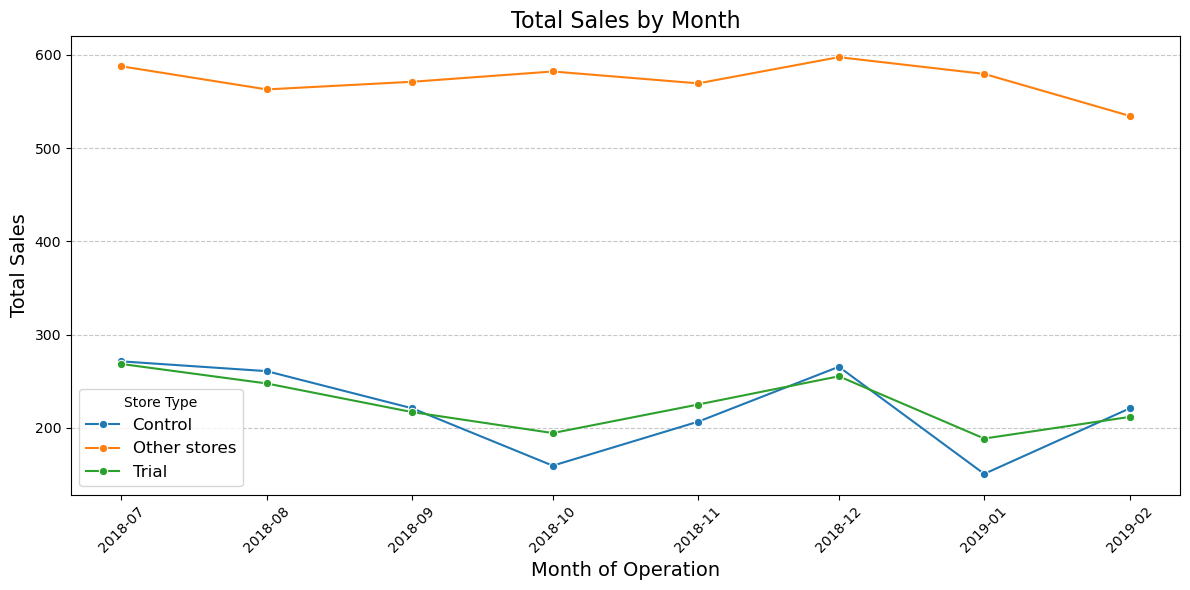

In [26]:
# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=past_sales, 
    x='TransactionMonth', 
    y='totSales', 
    hue='Store_type', 
    marker='o'
)

# Customize the plot
plt.title("Total Sales by Month", fontsize=16)
plt.xlabel("Month of Operation", fontsize=14)
plt.ylabel("Total Sales", fontsize=14)
plt.legend(title="Store Type", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


## 

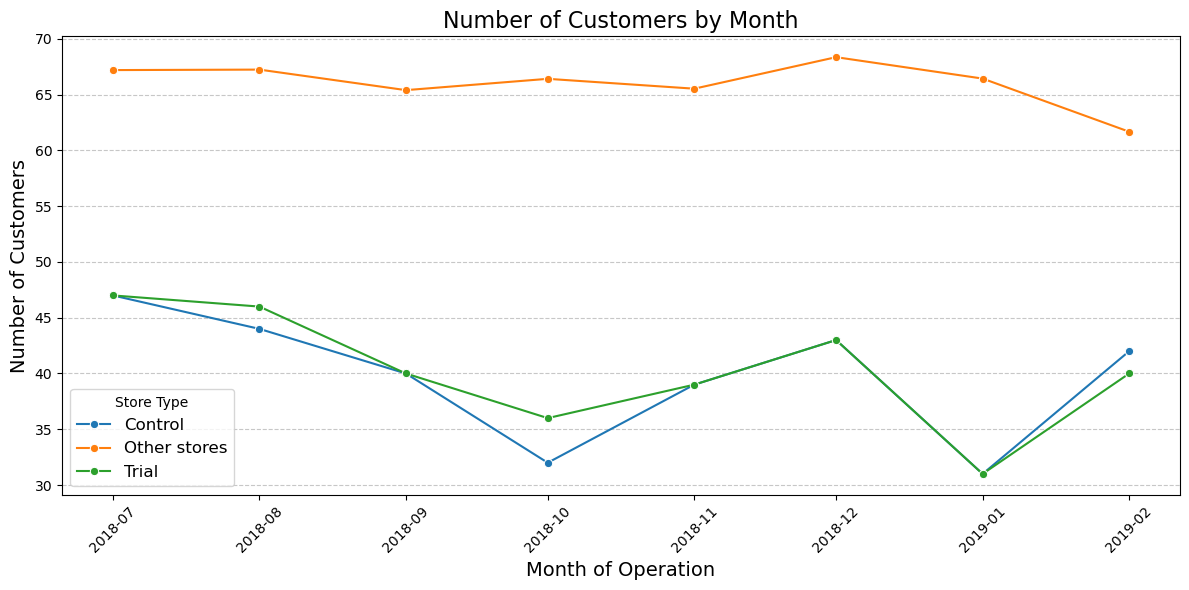

In [28]:
# Calculate average number of customers for each month and store type
past_customers = (
    measure_over_time
    .groupby(['YEARMONTH', 'Store_type'], as_index=False)
    .agg(nCustomers=('nCustomers', 'mean'))
)

# Convert YEARMONTH to a datetime format for plotting
past_customers['TransactionMonth'] = pd.to_datetime(past_customers['YEARMONTH'], format='%Y%m')

# Filter to the period before March 2019
past_customers = past_customers[past_customers['YEARMONTH'] < '201903']
# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=past_customers, 
    x='TransactionMonth', 
    y='nCustomers', 
    hue='Store_type', 
    marker='o'
)

# Customize the plot
plt.title("Number of Customers by Month", fontsize=16)
plt.xlabel("Month of Operation", fontsize=14)
plt.ylabel("Number of Customers", fontsize=14)
plt.legend(title="Store Type", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


## Comparison of results during trial

In [29]:
# Calculate total sales for the trial store and control store during the pre-trial period
trial_store_sales = pre_trial_measures[
    (pre_trial_measures['STORE_NBR'] == trial_store)
]['totSales'].sum()

control_store_sales = pre_trial_measures[
    (pre_trial_measures['STORE_NBR'] == control_store_id)
]['totSales'].sum()

# Calculate the scaling factor
scaling_factor = trial_store_sales / control_store_sales

print(f"Scaling Factor for Control Store Sales: {scaling_factor}")


Scaling Factor for Control Store Sales: 1.0397523623330076


In [30]:
# Create a copy of the original data to avoid modifying it directly
measure_over_time_sales = measure_over_time.copy()

# Apply the scaling factor to the control store's sales
measure_over_time_sales.loc[
    measure_over_time_sales['STORE_NBR'] == control_store_id, 'scaledControlSales'
] = measure_over_time_sales['totSales'] * scaling_factor

# Verify the scaled control sales
scaled_control_sales = measure_over_time_sales[
    measure_over_time_sales['STORE_NBR'] == control_store_id
][['YEARMONTH', 'totSales', 'scaledControlSales']]

print("\nScaled Control Sales:")
print(scaled_control_sales.head())



Scaled Control Sales:
     YEARMONTH  totSales  scaledControlSales
2695    201807     271.2          281.980841
2696    201808     260.7          271.063441
2697    201809     220.9          229.681297
2698    201810     159.3          165.632551
2699    201811     206.5          214.708863


In [35]:
# Pivot the table
trial_control_sales_pivot = trial_and_control_sales.pivot_table(
    index='YEARMONTH',
    columns='STORE_NBR',
    values=['totSales', 'scaledControlSales']
)

# Flatten multi-level column index
trial_control_sales_pivot.columns = ['_'.join(map(str, col)) for col in trial_control_sales_pivot.columns]
trial_control_sales_pivot = trial_control_sales_pivot.reset_index()

# Display the flattened pivot table
print("Flattened Pivot Table:")
print(trial_control_sales_pivot.head())


Flattened Pivot Table:
  YEARMONTH  scaledControlSales_233  totSales_77  totSales_233
0    201902              229.473346        211.6         220.7
1    201903              187.779277        255.1         180.6
2    201904              149.932291        258.1         144.2


In [36]:
# Rename columns to make them clear
trial_control_sales_pivot.columns = [
    'YEARMONTH',
    'Trial_Sales',
    'Control_Scaled_Sales'
]

# Verify the renamed table
print("\nRenamed Columns:")
print(trial_control_sales_pivot.head())


ValueError: Length mismatch: Expected axis has 4 elements, new values have 3 elements